In [1]:
import numpy as np
import pandas as pd
from typing import List, Union
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import RocCurveDisplay
import talib as ta
import matplotlib.pyplot as plt
from sklearn.model_selection._split import _BaseKFold
from typing import Tuple, Optional, Generator, Any, Union
from sklearn.metrics import log_loss, accuracy_score, RocCurveDisplay, auc
from scipy.stats import norm, skew, kurtosis



######################## Auxillary Functions #####################################

In [2]:
def get_volume_bars(prices: np.ndarray, vols: np.ndarray,
                    times: np.ndarray, bar_vol: int) -> np.ndarray:
    bars = np.zeros(shape=(len(prices), 6), dtype=object)
    ind = 0
    last_tick = 0
    cur_volume = 0
    for i in range(len(prices)):
        cur_volume += vols[i]
        if cur_volume >= bar_vol:
            bars[ind][0] = pd.Timestamp(times[i - 1])            # time
            bars[ind][1] = prices[last_tick]                     # open
            bars[ind][2] = np.max(prices[last_tick: i + 1])      # high
            bars[ind][3] = np.min(prices[last_tick: i + 1])      # low
            bars[ind][4] = prices[i]                             # close
            bars[ind][5] = np.sum(vols[last_tick: i + 1])        # volume
            cur_volume = 0
            last_tick = i + 1
            ind += 1
    return bars[:ind]

In [3]:
def getTEvents(gRaw: pd.Series, h: float) -> np.ndarray:
    """Input is close series, output is the index when the CUSUM > h or CUSUM < -h"""

    gRaw = gRaw[~gRaw.index.duplicated(keep='first')]
    tEvents, sPos, sNeg = [], 0, 0
    diff = gRaw.diff() # Calculate the 
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos + diff.loc[i]), min(0, sNeg + diff.loc[i])
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
        elif sPos > h:
            sPos = 0
            tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

In [4]:
def get_daily_vol(close: pd.Series, span0: int = 20) -> pd.Series:
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]) # This would result in the index in the left is tmr, in the right is today. Both index are in the closeserries
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1    # daily returns
    df0 = df0.ewm(span=span0).std()
    return df0

In [5]:
def get_returns(bars: np.ndarray) -> np.ndarray:
    """Calculate the returns of time series"""
    close_prices = pd.Series(bars[:, 4], index=bars[:, 0])
    return (close_prices.diff() / close_prices)[1:, ].astype(float)

In [6]:
def add_vertical_barrier(close: pd.Series, tEvents: np.ndarray, numDays: int) -> pd.Series:
    t1 = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=tEvents[:t1.shape[0]])    # Index is tEvents and t1 is 1 day after tEvents that has in dollar bars
    return t1

In [7]:
def apply_tripple_barrier(close: pd.Series, events: pd.DataFrame,
                                   pt_sl: List, molecule: np.ndarray) -> pd.DataFrame:
    '''
    Labeling observations using tripple-barrier method
    
        Parameters:
            close (pd.Series): close prices of bars
            events (pd.DataFrame): dataframe with columns:
                                   - t1: The timestamp of vertical barrier (if np.nan, there will not be
                                         a vertical barrier)
                                   - trgt: The unit width of the horizontal barriers
            pt_sl (list): list of two non-negative float values:
                          - pt_sl[0]: The factor that multiplies trgt to set the width of the upper barrier.
                                      If 0, there will not be an upper barrier.
                          - pt_sl[1]: The factor that multiplies trgt to set the width of the lower barrier.
                                      If 0, there will not be a lower barrier.
            molecule (np.ndarray):  subset of event indices that will be processed by a
                                    single thread (will be used later)
        
        Returns:
            out (pd.DataFrame): dataframe with columns [pt, sl, t1] corresponding to timestamps at which
                                each barrier was touched (if it happened)
    '''
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if pt_sl[0] > 0:
        pt = pt_sl[0] * events_['trgt']
    else:
        pt = pd.Series(data=[np.nan] * len(events.index), index=events.index)    # NaNs
    if pt_sl[1] > 0:
        sl = -pt_sl[1] * events_['trgt']
    else:
        sl = pd.Series(data=[np.nan] * len(events.index), index=events.index)    # NaNs
    
    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0 = close[loc: t1]                                       # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side']     # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()        # earlisest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()        # earlisest profit taking
    return out

In [8]:
def get_events_tripple_barrier(
    close: pd.Series, tEvents: np.ndarray, pt_sl: float, trgt: pd.Series, minRet: float,
    numThreads: int = 1, t1: Union[pd.Series, bool] = False, side: pd.Series = None
) -> pd.DataFrame:
    '''
    Getting times of the first barrier touch
    
        Parameters:
            close (pd.Series): close prices of bars
            tEvents (np.ndarray): np.ndarray of timestamps that seed every barrier (they can be generated
                                  by CUSUM filter for example)
            pt_sl (float): non-negative float that sets the width of the two barriers (if 0 then no barrier)
            trgt (pd.Series): s series of targets expressed in terms of absolute returns
            minRet (float): minimum target return required for running a triple barrier search
            numThreads (int): number of threads to use concurrently
            t1 (pd.Series): series with the timestamps of the vertical barriers (pass False
                            to disable vertical barriers)
            side (pd.Series) (optional): metalabels containing sides of bets
        
        Returns:
            events (pd.DataFrame): dataframe with columns:
                                       - t1: timestamp of the first barrier touch
                                       - trgt: target that was used to generate the horizontal barriers
                                       - side (optional): side of bets
    '''
    if len(tEvents) > 0:
        trgt = trgt.loc[trgt.index.intersection(tEvents)] # Data trgt la daily vol co so ngay it hon close serues
    trgt = trgt[trgt > minRet]
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)
    if side is None:
        side_, pt_sl_ = pd.Series(np.array([1.] * len(trgt.index)), index=trgt.index), [pt_sl[0], pt_sl[0]]
    else:
        side_, pt_sl_ = side.loc[trgt.index.intersection(side.index)], pt_sl[:2]
    # Events is top index that > MinRet
    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_}, axis=1).dropna(subset=['trgt'])
    df0 = apply_tripple_barrier(close, events, pt_sl_, events.index)
#     df0 = mpPandasObj(func=apply_tripple_barrier, pdObj=('molecule', events.index),
#                       numThreads=numThreads, close=close, events=events, pt_sl=[pt_sl, pt_sl])
    events['t1'] = df0.dropna(how='all').min(axis=1)
    if side is None:
        events = events.drop('side', axis=1)
    return events

In [9]:
def get_bins(close: pd.Series, events: pd.DataFrame, t1: Union[pd.Series, bool] = False) -> pd.DataFrame:
    '''
    Generating labels with possibility of knowing the side (metalabeling)
    
        Parameters:
            close (pd.Series): close prices of bars
            events (pd.DataFrame): dataframe returned by 'get_events' with columns:
                                   - index: event starttime
                                   - t1: event endtime
                                   - trgt: event target
                                   - side (optional): position side
            t1 (pd.Series): series with the timestamps of the vertical barriers (pass False
                            to disable vertical barriers)
        
        Returns:
            out (pd.DataFrame): dataframe with columns:
                                       - ret: return realized at the time of the first touched barrier
                                       - bin: if metalabeling ('side' in events), then {0, 1} (take the bet or pass)
                                              if no metalabeling, then {-1, 1} (buy or sell)
    '''
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index] - 1 # Tinh return khi cham barrier
    if 'side' in events_:
        out['ret'] *= events_['side']
    out['bin'] = np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret'] <= 0, 'bin'] = 0
    else:
        if t1 is not None:
            vertical_first_touch_idx = events_[events_['t1'].isin(t1.values)].index
            out.loc[vertical_first_touch_idx, 'bin'] = 0
    return out

In [10]:
def drop_labels(labels: pd.DataFrame, min_pct: float = 0.05) -> pd.DataFrame:
    while True:
        df0 = labels['bin'].value_counts(normalize=True)
        if df0.min() > min_pct or df0.shape[0] < 3:
            break
        print('dropped label', df0.argmin(), df0.min())
        labels = labels[labels['bin'] != df0.index[df0.argmin()]]
    return labels

In [11]:
def get_bollinger_bands(dollar_bars: pd.DataFrame, alpha: float) -> np.ndarray:
    prices = dollar_bars['close']                                    # taking close prices
    ma = (prices.rolling(30, min_periods=1).mean())                  # 30 bars moving average
    sigma = prices.rolling(30, min_periods=1).std()
    sigma[0] = 0
    b_upper, b_lower = (ma + alpha * sigma), (ma - alpha * sigma)    # bollinger bounds    
    return np.array([ma, b_upper, b_lower])


def get_upside_bars_bb(df: pd.DataFrame) -> pd.DataFrame:
    return df[(df['open'] < df['b_upper']) & (df['close'] > df['b_upper'])]

def get_downside_bars_bb(df: pd.DataFrame) -> np.ndarray:
    return df[(df['open'] > df['b_lower']) & (df['close'] < df['b_lower'])]

In [12]:
def print_results(rf: RandomForestClassifier, X_test: np.ndarray,
                  y_test: np.ndarray, y_pred: np.ndarray) -> None:
    print(f'RF accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'RF precision: {precision_score(y_test, y_pred)}')
    print(f'RF recall: {recall_score(y_test, y_pred)}')
    RocCurveDisplay.from_estimator(rf, X_test, y_test)

In [13]:
# Function to calculate Sharpe Ratio
def sharpe_ratio(returns, risk_free_rate=0.0):
    return (returns.mean() - risk_free_rate) / returns.std() * np.sqrt(252)

# Function to calculate maximum drawdown
def max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

# Function to calculate underwater time
def underwater_time(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return (drawdown != 0).sum()

# Function to calculate hit ratio (percentage of positive returns)
def hit_ratio(returns):
    return (returns > 0).mean()

# Function to calculate cumulative return
def cumulative_return(returns):
    return (1 + returns).prod() - 1

# Function to calculate Calmar Ratio
def calmar_ratio(returns):
    annual_return = cumulative_return(returns) * 252 / len(returns)
    max_dd = abs(max_drawdown(returns))
    return annual_return / max_dd if max_dd != 0 else np.nan

# Create a summary for each strategy's return series
def summarize_backtest_stats(returns):
    summary = {
        'Sharpe Ratio': sharpe_ratio(returns),
        'Max Drawdown': max_drawdown(returns),
        'Underwater Time (days)': underwater_time(returns),
        'Hit Ratio': hit_ratio(returns),
        'Cumulative Return': cumulative_return(returns),
        'Calmar Ratio': calmar_ratio(returns)
    }
    return summary

In [14]:
class PurgedKFold(_BaseKFold):
    '''
    Extend KFold class to work with labels that span intervals.
    The train is purged of observations overlapping test-label intervals.
    Test set is assumed contiguous (shuffle=False), without training samples in between.
    '''
    
    def __init__(
        self, n_splits: int = 3, t1: Optional[pd.Series] = None, pctEmbargo: float = 0.0
    ) -> None:
        if not isinstance(t1, pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold, self).__init__(n_splits, shuffle=False, random_state=None)
        self.t1 = t1
        self.pctEmbargo = pctEmbargo
        
    def split(
        self, X: pd.DataFrame, y: Optional[pd.Series] = None, groups: Optional[np.ndarray] = None
    ) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
        if (X.index == self.t1.index).sum() != len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index')
        indices = np.arange(X.shape[0])
        mbrg = int(X.shape[0] * self.pctEmbargo)
        test_starts = [(i[0], i[-1] + 1) for i in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for i, j in test_starts:
            t0 = self.t1.index[i]    # start of test set
            test_indices = indices[i: j]
            maxT1Idx = self.t1.index.searchsorted(self.t1[test_indices].max())
            train_indices = self.t1.index.searchsorted(self.t1[self.t1 <= t0].index)
            if maxT1Idx < X.shape[0]:    # right train (with embargo)
                train_indices = np.concatenate((train_indices, indices[maxT1Idx + mbrg:]))
            yield train_indices, test_indices

In [15]:
def plot_cv_results(cv: Union[StratifiedKFold, PurgedKFold], clf: Any, X: pd.DataFrame, y: pd.Series) -> None:
    '''
    Plots ROC curve for each iteration of cross-validation together with the mean curve
    and print cv accuracy.
    Based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval
    '''
    for scoring in ['accuracy', 'precision', 'recall']:
        score = cross_val_score(estimator=clf, X=X, y=y, scoring=scoring, cv=cv, n_jobs=-1)
        print(f'CV mean {scoring}: {np.mean(score)}')
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(12, 8))
    for i, (train, test) in enumerate(cv.split(X, y)):
        clf.fit(np.array(X)[train], np.array(y)[train])
        viz = RocCurveDisplay.from_estimator(clf, np.array(X)[test], np.array(y)[test], name="ROC fold {}".format(i),
                                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color="b", label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
            lw=2, alpha=0.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()

######################## Resample volume bar #####################################

In [16]:
coin = 'BTCUSDT'

In [17]:
data_folder_link = '/Users/khai/Desktop/alphanest/alpha-nest-backtest/data/crypto/binance/kline'
df = pd.read_csv(f'{data_folder_link}/{coin}/FULL.csv',parse_dates=['ts'])[['ts','close','volume']]
df.columns = ['datetime','close','volume']

In [18]:
volume_bars = get_volume_bars(df['close'].values, df['volume'].values, df['datetime'].values, 1000)
volume_bars_df = pd.DataFrame(data=volume_bars[:, 1:], index=volume_bars[:, 0],
                           columns=['open', 'high', 'low', 'close', 'volume'])
volume_bars_df = volume_bars_df[~volume_bars_df.index.duplicated(keep='first')]

In [19]:
######################### CUSUM Filtering #####################################
mean_std = get_daily_vol(volume_bars_df['close']).mean()
volume_ret = get_returns(volume_bars)

In [30]:
train_ret = volume_ret[(volume_ret.index>'2022-06-01')&(volume_ret.index<'2023-12-31')].copy()

# Calculate statistics
mean_ret = train_ret.mean()  # Calculate the mean
std_ret = train_ret.std()    # Calculate the standard deviation
skew_ret = train_ret.skew()  # Calculate the skewness
kurt_ret = train_ret.kurt()  # Calculate the kurtosis

# Create a summary table
summary_table = pd.DataFrame({
    'Statistic': ['Mean', 'Standard Deviation', 'Skewness', 'Kurtosis'],
    'Value': [mean_ret, std_ret, skew_ret, kurt_ret]
})

# Display the summary table
summary_table


Statistic         Value
0                Mean  3.418569e-07
1  Standard Deviation  1.549464e-03
2            Skewness -1.478941e-01
3            Kurtosis  4.322872e+01

In [31]:
test_ret = volume_ret[(volume_ret.index<'2022-06-01')|(volume_ret.index>'2023-12-31')].copy()

# Calculate statistics
mean_ret = test_ret.mean()  # Calculate the mean
std_ret = test_ret.std()    # Calculate the standard deviation
skew_ret = test_ret.skew()  # Calculate the skewness
kurt_ret = test_ret.kurt()  # Calculate the kurtosis

# Create a summary table
summary_table = pd.DataFrame({
    'Statistic': ['Mean', 'Standard Deviation', 'Skewness', 'Kurtosis'],
    'Value': [mean_ret, std_ret, skew_ret, kurt_ret]
})

# Display the summary table
summary_table


Statistic         Value
0                Mean -9.701879e-07
1  Standard Deviation  2.122895e-03
2            Skewness -8.437650e-02
3            Kurtosis  7.284198e+00

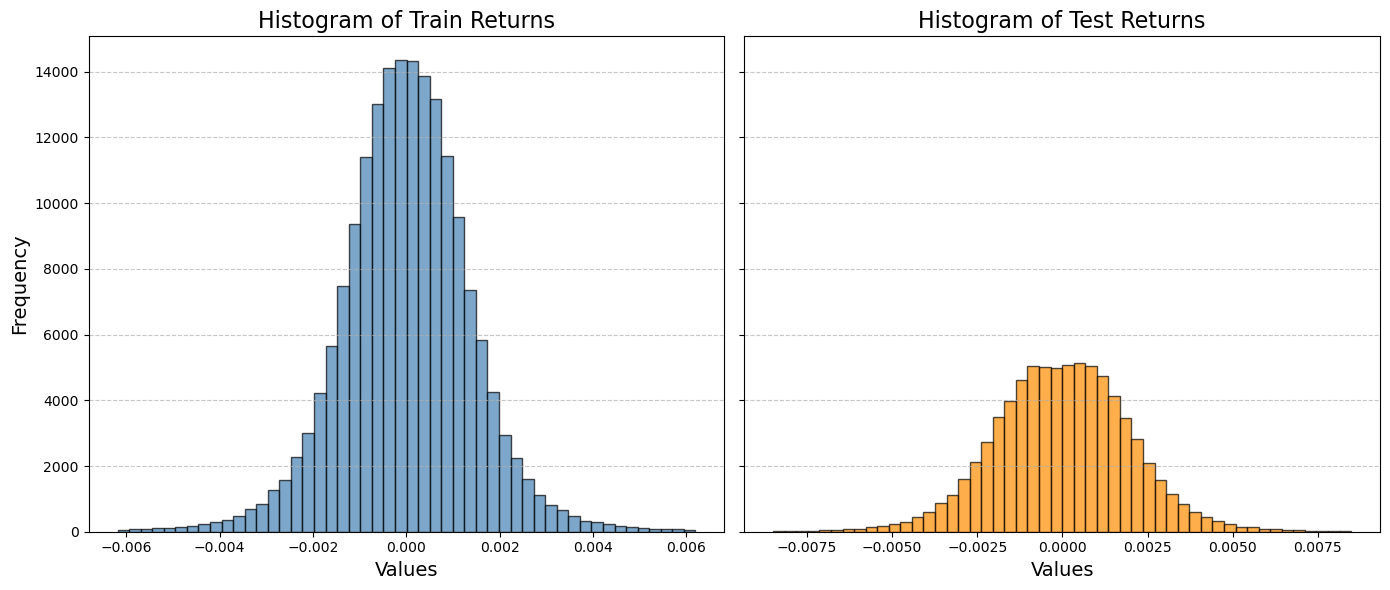

In [32]:
import matplotlib.pyplot as plt
from scipy import stats

# Calculate Z-scores
z_scores = stats.zscore(train_ret)
z_scores_test = stats.zscore(test_ret)

# Filter out points with Z-scores greater than a threshold (e.g., 4)
threshold = 4
filtered_train_ret = [x for x, z in zip(train_ret, z_scores) if np.abs(z) < threshold]
filtered_test_ret = [x for x, z in zip(test_ret, z_scores_test) if np.abs(z) < threshold]

# Plot histograms of filtered data side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Histogram for filtered_train_ret
axes[0].hist(filtered_train_ret, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Values', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].set_title('Histogram of Train Returns', fontsize=16)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Histogram for filtered_test_ret
axes[1].hist(filtered_test_ret, bins=50, alpha=0.7, color='darkorange', edgecolor='black')
axes[1].set_xlabel('Values', fontsize=14)
axes[1].set_title('Histogram of Test Returns', fontsize=16)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [22]:
tEvents = getTEvents(volume_ret, h=mean_std) # CUMSUM FIlter timestep,
chosen_bars_df = volume_bars_df.loc[tEvents, :]


In [33]:
######################### TRIPPLE BARRIER #####################################
t1 = add_vertical_barrier(volume_bars_df['close'], tEvents, numDays=1) # Vertical Barriers


# t1 = add_vertical_barrier(volume_bars_df['close'], tEvents, numDays=1) # Vertical Barriers

# events = get_events_tripple_barrier(close=volume_bars_df['close'], tEvents=tEvents, pt_sl=[1, 1],
#                                     trgt=get_daily_vol(volume_bars_df['close']), minRet=0.000,
#                                     numThreads=1, t1=t1) # The column t1 of output is record as time hit the pt or sl, NOI CHUNG CHI RECORD EVENT 
# ######################### LABELING #####################################
# labels = get_bins(close=volume_bars_df['close'], events=events, t1=t1) # ham get bins co phan vertical 

In [34]:
######################### Bollinger Band Trading Strategy #####################################


ma, b_upper, b_lower = get_bollinger_bands(volume_bars_df, 1)
volume_bars_df_bb = volume_bars_df.copy(deep=True)
volume_bars_df_bb['ma'], volume_bars_df_bb['b_upper'], volume_bars_df_bb['b_lower'] = ma, b_upper, b_lower


up_timestamps, down_timestamps = get_upside_bars_bb(volume_bars_df_bb), get_downside_bars_bb(volume_bars_df_bb)

/var/folders/77/n2v890f56zddnfjl03fvbfh40000gn/T/ipykernel_12725/2183006775.py:5: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  sigma[0] = 0


In [35]:
side_index = up_timestamps.index.union(down_timestamps.index) # Uninon ca 2 index
side_data = []
for idx in side_index:
    if idx in up_timestamps.index:
        side_data.append(1)
    else:
        side_data.append(-1)
side = pd.Series(data=side_data, index=side_index)
# tEvents = []
events_bb = get_events_tripple_barrier(close=volume_bars_df['close'], tEvents=tEvents, pt_sl=[1, 2],
                                       trgt=get_daily_vol(volume_bars_df['close']), minRet=0.000,
                                       numThreads=1, t1=t1, side=side) # if side is not None mean meta-labeling
events_bb = events_bb.dropna() # events_ma just contain index of events above, the side is the signal of MA Strategy
bins_bb = get_bins(close=volume_bars_df['close'], events=events_bb, t1=t1)
print(bins_bb.head()) # meta-labeling of signal in bin column, ret is the true return when trading the MA

                              ret bin
2022-01-02 03:48:59.999  0.006761   1
2022-01-02 09:21:59.999    0.0052   1
2022-01-02 12:03:59.999 -0.010052   0
2022-01-02 15:45:59.999  0.004417   1
2022-01-02 18:53:59.999  0.008134   1


######################## feature engineering #####################################

In [24]:
sine, leadsine = ta.HT_SINE(volume_bars_df_bb.close)

In [25]:
features_df = pd.DataFrame(index=bins_bb.index)
features_df['std'] = volume_bars_df_bb.close.pct_change().rolling(10).std().loc[bins_bb.index]
features_df['dominant_cycle'] = ta.HT_DCPERIOD(volume_bars_df_bb.close).loc[bins_bb.index]
features_df['dominant_phase'] = ta.HT_DCPHASE(volume_bars_df_bb.close).loc[bins_bb.index]
features_df['trend_mode'] = ta.HT_TRENDMODE(volume_bars_df_bb.close).loc[bins_bb.index]
features_df['sine'] = sine.loc[bins_bb.index]
features_df['leadsine'] = leadsine.loc[bins_bb.index]
features_df['sine_gt_leadsine'] = (sine>leadsine).loc[bins_bb.index]
features_df['bin'] = bins_bb['bin']

In [26]:
feature_columns = ['std','dominant_cycle','dominant_phase','trend_mode','sine_gt_leadsine','sine','leadsine']

######################## Performing Cross Validation #####################################


In [27]:
# X = features_df[feature_columns].copy()
# y = features_df['bin'].astype(int)

# cv = PurgedKFold(n_splits=5, t1=t1[X.index], pctEmbargo=0.05)
# clf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', n_jobs=-1, random_state=42)
# plot_cv_results(cv, clf, X, y)

######################## Model Fitting #####################################

In [28]:
# Set the threshold date for splitting
split_date1 = '2022-06-01'
split_date2 = '2023-12-31'



# Create the train and test splits based on the index
X_train = features_df.loc[(features_df.index > split_date1) & (features_df.index < split_date2), feature_columns].values
y_train = features_df.loc[(features_df.index > split_date1) & (features_df.index < split_date2), 'bin'].values.astype(int)

X_test1 = features_df.loc[features_df.index < split_date1, feature_columns].values
y_test1 = features_df.loc[features_df.index < split_date1, 'bin'].values.astype(int)

X_test2 = features_df.loc[features_df.index > split_date2, feature_columns].values
y_test2 = features_df.loc[features_df.index > split_date2, 'bin'].values.astype(int)

In [29]:
print(len(X_train))

2034


In [30]:
import lightgbm as lgb
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import recall_score, make_scorer
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")


# Create the train and test splits based on the index
SEED = 42
X_train_tunning = features_df.loc[(features_df.index > split_date1) & (features_df.index < split_date2), feature_columns]
y_train_tunning = features_df.loc[(features_df.index > split_date1) & (features_df.index < split_date2), 'bin'].values.astype(int)
# Objective function for optuna
def objective(trial):
    # Define the hyperparameters to tune
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),  # Number of trees
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),  # Learning rate
        'max_depth': trial.suggest_int('max_depth', 3, 12),  # Max depth of the tree
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),  # Number of leaves
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),  # Minimum child weight
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Feature subsample ratio
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Row subsample ratio
        'class_weight': 'balanced',  # Handle class imbalance
        'random_state': SEED,  # Random state for reproducibility
        'n_jobs': -1  # Use all processors
    }

    # Define the LightGBM classifier with trial-suggested parameters
    clf = lgb.LGBMClassifier(**param)
    
    # Cross-validation with PurgedKFold
    cv = PurgedKFold(n_splits=5, t1=t1[X_train_tunning.index], pctEmbargo=0.05)
    
    # We need to optimize for recall, so we will use recall_score with cross_val_score
    scorer = make_scorer(recall_score)
    
    # Perform cross-validation
    cv_results = cross_val_score(clf, X_train_tunning, y_train_tunning, cv=cv, scoring=scorer)
    
    # Return the mean recall score for this trial
    return np.mean(cv_results)

# Create an Optuna study to maximize recall
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=50)




/Users/khai/opt/anaconda3/envs/nest/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-10-22 07:22:05,632] A new study created in memory with name: no-name-949ad836-511d-4248-ae8f-3f1e66007209


[LightGBM] [Info] Number of positive: 939, number of negative: 580
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 1519, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-10-22 07:22:06,041] Trial 0 finished with value: 0.5622472314978548 and parameters: {'n_estimators': 296, 'learning_rate': 0.06114783572330438, 'max_depth': 4, 'num_leaves': 140, 'min_child_weight': 3.3108907864137356, 'colsample_bytree': 0.5850695375434979, 'subsample': 0.6009348136937176}. Best is trial 0 with value: 0.5622472314978548.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:06,956] Trial 1 finished with value: 0.5716319238163615 and parameters: {'n_estimators': 500, 'learning_rate': 0.0365674223629253, 'max_depth': 7, 'num_leaves': 38, 'min_child_weight': 8.831976204757998, 'colsample_bytree': 0.9121857681934504, 'subsample': 0.5892683417976905}. Best is trial 1 with value: 0.5716319238163615.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:07,153] Trial 2 finished with value: 0.5294769833173106 and parameters: {'n_estimators': 78, 'learning_rate': 0.024601116085412524, 'max_depth': 9, 'num_leaves': 98, 'min_child_weight': 3.699256999621767, 'colsample_bytree': 0.8242385550797915, 'subsample': 0.7772243067406683}. Best is trial 1 with value: 0.5716319238163615.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:07,294] Trial 3 finished with value: 0.5495450431859751 and parameters: {'n_estimators': 137, 'learning_rate': 0.17807832398498707, 'max_depth': 3, 'num_leaves': 147, 'min_child_weight': 8.596105485877146, 'colsample_bytree': 0.8712043976712556, 'subsample': 0.6209990271591252}. Best is trial 1 with value: 0.5716319238163615.


[LightGBM] [Info] Number of positive: 939, number of negative: 580
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 1519, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-10-22 07:22:07,511] Trial 4 finished with value: 0.5361193411859306 and parameters: {'n_estimators': 265, 'learning_rate': 0.06687236028258647, 'max_depth': 3, 'num_leaves': 138, 'min_child_weight': 2.136141709647142, 'colsample_bytree': 0.7943240577378909, 'subsample': 0.6524512326776322}. Best is trial 1 with value: 0.5716319238163615.


[LightGBM] [Info] Number of positive: 939, number of negative: 580
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 1519, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-10-22 07:22:08,034] Trial 5 finished with value: 0.6067492681881532 and parameters: {'n_estimators': 349, 'learning_rate': 0.1562825207920806, 'max_depth': 6, 'num_leaves': 92, 'min_child_weight': 1.8481460998759522, 'colsample_bytree': 0.8608108036866905, 'subsample': 0.9509480297749491}. Best is trial 5 with value: 0.6067492681881532.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:08,374] Trial 6 finished with value: 0.5606488000942029 and parameters: {'n_estimators': 462, 'learning_rate': 0.09002664176488026, 'max_depth': 3, 'num_leaves': 44, 'min_child_weight': 8.415442676807661, 'colsample_bytree': 0.5375447465204362, 'subsample': 0.5838698696988069}. Best is trial 5 with value: 0.6067492681881532.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:08,646] Trial 7 finished with value: 0.5992533871011025 and parameters: {'n_estimators': 141, 'learning_rate': 0.18241494915725925, 'max_depth': 8, 'num_leaves': 77, 'min_child_weight': 7.125462788581543, 'colsample_bytree': 0.8261185123811545, 'subsample': 0.6244787554665778}. Best is trial 5 with value: 0.6067492681881532.


[LightGBM] [Info] Number of positive: 979, number of negative: 541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-10-22 07:22:09,033] Trial 8 finished with value: 0.599804590111521 and parameters: {'n_estimators': 434, 'learning_rate': 0.16181015634321202, 'max_depth': 4, 'num_leaves': 51, 'min_child_weight': 1.395036885603826, 'colsample_bytree': 0.7465442871338878, 'subsample': 0.6364557041848433}. Best is trial 5 with value: 0.6067492681881532.


[LightGBM] [Info] Number of positive: 1022, number of negative: 605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 1627, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-10-22 07:22:09,988] Trial 9 finished with value: 0.6187472007868227 and parameters: {'n_estimators': 389, 'learning_rate': 0.04648822689646918, 'max_depth': 12, 'num_leaves': 46, 'min_child_weight': 4.803639356080876, 'colsample_bytree': 0.9737312446227935, 'subsample': 0.6170310113356294}. Best is trial 9 with value: 0.6187472007868227.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:10,662] Trial 10 finished with value: 0.6176599714835707 and parameters: {'n_estimators': 363, 'learning_rate': 0.12731374437599086, 'max_depth': 12, 'num_leaves': 20, 'min_child_weight': 5.581360049683577, 'colsample_bytree': 0.9991858220851391, 'subsample': 0.5002921507645557}. Best is trial 9 with value: 0.6187472007868227.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:11,330] Trial 11 finished with value: 0.627708567292847 and parameters: {'n_estimators': 370, 'learning_rate': 0.12775199075825583, 'max_depth': 12, 'num_leaves': 21, 'min_child_weight': 5.4250700496909605, 'colsample_bytree': 0.9939553278433488, 'subsample': 0.5072926775011343}. Best is trial 11 with value: 0.627708567292847.


[LightGBM] [Info] Number of positive: 939, number of negative: 580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 1519, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-10-22 07:22:12,054] Trial 12 finished with value: 0.6312741409191007 and parameters: {'n_estimators': 389, 'learning_rate': 0.12414004973774151, 'max_depth': 12, 'num_leaves': 21, 'min_child_weight': 5.4059426664151164, 'colsample_bytree': 0.9763009927134572, 'subsample': 0.5016954351584484}. Best is trial 12 with value: 0.6312741409191007.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:12,682] Trial 13 finished with value: 0.6081079912389343 and parameters: {'n_estimators': 270, 'learning_rate': 0.1268900470002353, 'max_depth': 11, 'num_leaves': 22, 'min_child_weight': 6.145424725491695, 'colsample_bytree': 0.6744988962391933, 'subsample': 0.502500798237132}. Best is trial 12 with value: 0.6312741409191007.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:13,462] Trial 14 finished with value: 0.6135904366264547 and parameters: {'n_estimators': 314, 'learning_rate': 0.10947272893126107, 'max_depth': 11, 'num_leaves': 74, 'min_child_weight': 7.036892400882726, 'colsample_bytree': 0.9345808205837016, 'subsample': 0.7853069014281686}. Best is trial 12 with value: 0.6312741409191007.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:14,005] Trial 15 finished with value: 0.6254483312649475 and parameters: {'n_estimators': 230, 'learning_rate': 0.13476776821914388, 'max_depth': 10, 'num_leaves': 63, 'min_child_weight': 4.467258551375997, 'colsample_bytree': 0.7021548742085886, 'subsample': 0.7077239879849789}. Best is trial 12 with value: 0.6312741409191007.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:14,905] Trial 16 finished with value: 0.6111445960346025 and parameters: {'n_estimators': 412, 'learning_rate': 0.09011587180733481, 'max_depth': 10, 'num_leaves': 119, 'min_child_weight': 9.782608054813245, 'colsample_bytree': 0.922180378118377, 'subsample': 0.8780729368863476}. Best is trial 12 with value: 0.6312741409191007.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:15,526] Trial 17 finished with value: 0.603912017428029 and parameters: {'n_estimators': 207, 'learning_rate': 0.1026737772281344, 'max_depth': 12, 'num_leaves': 33, 'min_child_weight': 6.67275763339036, 'colsample_bytree': 0.9895725461202973, 'subsample': 0.5378274777349107}. Best is trial 12 with value: 0.6312741409191007.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:16,186] Trial 18 finished with value: 0.6296689608394326 and parameters: {'n_estimators': 339, 'learning_rate': 0.14930875346524786, 'max_depth': 9, 'num_leaves': 62, 'min_child_weight': 3.3257199660574037, 'colsample_bytree': 0.9385326672300313, 'subsample': 0.7247914259306153}. Best is trial 12 with value: 0.6312741409191007.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:16,898] Trial 19 finished with value: 0.6303678187640175 and parameters: {'n_estimators': 327, 'learning_rate': 0.15540965931893774, 'max_depth': 8, 'num_leaves': 59, 'min_child_weight': 2.870608747175929, 'colsample_bytree': 0.8965114796287941, 'subsample': 0.7111182156646976}. Best is trial 12 with value: 0.6312741409191007.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:17,559] Trial 20 finished with value: 0.6395820370439154 and parameters: {'n_estimators': 456, 'learning_rate': 0.18634556634390775, 'max_depth': 6, 'num_leaves': 111, 'min_child_weight': 2.549430834669477, 'colsample_bytree': 0.8801757685074939, 'subsample': 0.8215273579017066}. Best is trial 20 with value: 0.6395820370439154.


[LightGBM] [Info] Number of positive: 939, number of negative: 580
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 1519, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-10-22 07:22:18,388] Trial 21 finished with value: 0.6311463596145821 and parameters: {'n_estimators': 460, 'learning_rate': 0.1991158373525202, 'max_depth': 6, 'num_leaves': 108, 'min_child_weight': 2.479233336347483, 'colsample_bytree': 0.8821834681841698, 'subsample': 0.840795031386621}. Best is trial 20 with value: 0.6395820370439154.


[LightGBM] [Info] Number of positive: 1022, number of negative: 605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 1627, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-10-22 07:22:19,090] Trial 22 finished with value: 0.6332635173215355 and parameters: {'n_estimators': 493, 'learning_rate': 0.18803755008912942, 'max_depth': 6, 'num_leaves': 110, 'min_child_weight': 2.6851032772165424, 'colsample_bytree': 0.771250402310547, 'subsample': 0.8470959688632296}. Best is trial 20 with value: 0.6395820370439154.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:19,907] Trial 23 finished with value: 0.627419025052933 and parameters: {'n_estimators': 494, 'learning_rate': 0.19634892602105805, 'max_depth': 6, 'num_leaves': 121, 'min_child_weight': 1.1735075774107588, 'colsample_bytree': 0.7667553708671184, 'subsample': 0.8637135381955088}. Best is trial 20 with value: 0.6395820370439154.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:20,453] Trial 24 finished with value: 0.610608020357853 and parameters: {'n_estimators': 430, 'learning_rate': 0.17999528156475914, 'max_depth': 5, 'num_leaves': 118, 'min_child_weight': 4.352424884296747, 'colsample_bytree': 0.6470352018908123, 'subsample': 0.9477478205066484}. Best is trial 20 with value: 0.6395820370439154.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:21,193] Trial 25 finished with value: 0.6211876531741538 and parameters: {'n_estimators': 455, 'learning_rate': 0.1724739836592148, 'max_depth': 7, 'num_leaves': 105, 'min_child_weight': 3.697001523155922, 'colsample_bytree': 0.73009114177498, 'subsample': 0.8282347220773645}. Best is trial 20 with value: 0.6395820370439154.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:21,810] Trial 26 finished with value: 0.6153993074180404 and parameters: {'n_estimators': 396, 'learning_rate': 0.14171323874392122, 'max_depth': 5, 'num_leaves': 129, 'min_child_weight': 2.8319594701035693, 'colsample_bytree': 0.829678266062507, 'subsample': 0.9058341125183531}. Best is trial 20 with value: 0.6395820370439154.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:22,427] Trial 27 finished with value: 0.6131661598927367 and parameters: {'n_estimators': 478, 'learning_rate': 0.16827792484996673, 'max_depth': 5, 'num_leaves': 89, 'min_child_weight': 1.7802105475137355, 'colsample_bytree': 0.959582894349449, 'subsample': 0.81210218984488}. Best is trial 20 with value: 0.6395820370439154.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:23,382] Trial 28 finished with value: 0.6238549220891907 and parameters: {'n_estimators': 428, 'learning_rate': 0.19009149026650177, 'max_depth': 7, 'num_leaves': 79, 'min_child_weight': 4.251544425668148, 'colsample_bytree': 0.7926909528555919, 'subsample': 0.9859704964895846}. Best is trial 20 with value: 0.6395820370439154.


[LightGBM] [Info] Number of positive: 939, number of negative: 580
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 1519, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-10-22 07:22:23,798] Trial 29 finished with value: 0.5631285545898759 and parameters: {'n_estimators': 390, 'learning_rate': 0.06497551819558908, 'max_depth': 4, 'num_leaves': 129, 'min_child_weight': 5.072659214885179, 'colsample_bytree': 0.6573522776527835, 'subsample': 0.6749242794662283}. Best is trial 20 with value: 0.6395820370439154.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:24,535] Trial 30 finished with value: 0.6005522478349299 and parameters: {'n_estimators': 452, 'learning_rate': 0.11344506919776617, 'max_depth': 6, 'num_leaves': 107, 'min_child_weight': 3.599218080220008, 'colsample_bytree': 0.5923044072912584, 'subsample': 0.7509180987394934}. Best is trial 20 with value: 0.6395820370439154.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:25,330] Trial 31 finished with value: 0.642817259051265 and parameters: {'n_estimators': 472, 'learning_rate': 0.19482081401643375, 'max_depth': 6, 'num_leaves': 108, 'min_child_weight': 2.958906852591111, 'colsample_bytree': 0.8739849392823901, 'subsample': 0.8402452009078891}. Best is trial 31 with value: 0.642817259051265.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:26,047] Trial 32 finished with value: 0.6223701420871256 and parameters: {'n_estimators': 494, 'learning_rate': 0.1864896587135555, 'max_depth': 5, 'num_leaves': 98, 'min_child_weight': 2.7361410339033836, 'colsample_bytree': 0.8466734710957532, 'subsample': 0.9052995807118598}. Best is trial 31 with value: 0.642817259051265.


[LightGBM] [Info] Number of positive: 1022, number of negative: 605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 1627, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-10-22 07:22:26,853] Trial 33 finished with value: 0.6449002517822822 and parameters: {'n_estimators': 478, 'learning_rate': 0.16812130217835355, 'max_depth': 7, 'num_leaves': 115, 'min_child_weight': 2.2589648900287322, 'colsample_bytree': 0.7895160781941506, 'subsample': 0.7952751210273189}. Best is trial 33 with value: 0.6449002517822822.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:27,852] Trial 34 finished with value: 0.6439810653497877 and parameters: {'n_estimators': 498, 'learning_rate': 0.1999034540649515, 'max_depth': 8, 'num_leaves': 113, 'min_child_weight': 2.252401493520642, 'colsample_bytree': 0.7782061393090721, 'subsample': 0.7952687895665657}. Best is trial 33 with value: 0.6449002517822822.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:28,843] Trial 35 finished with value: 0.6365494108038184 and parameters: {'n_estimators': 467, 'learning_rate': 0.19933544880670978, 'max_depth': 8, 'num_leaves': 130, 'min_child_weight': 1.1753364728952311, 'colsample_bytree': 0.8035039648169059, 'subsample': 0.7921418962832906}. Best is trial 33 with value: 0.6449002517822822.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:29,682] Trial 36 finished with value: 0.6257738445869678 and parameters: {'n_estimators': 437, 'learning_rate': 0.16706148660877862, 'max_depth': 7, 'num_leaves': 149, 'min_child_weight': 2.126178833151616, 'colsample_bytree': 0.8574380117008621, 'subsample': 0.7603065170753917}. Best is trial 33 with value: 0.6449002517822822.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:29,924] Trial 37 finished with value: 0.4885511976265609 and parameters: {'n_estimators': 65, 'learning_rate': 0.010595324908349218, 'max_depth': 9, 'num_leaves': 98, 'min_child_weight': 1.6349808645247692, 'colsample_bytree': 0.8968874243131801, 'subsample': 0.8118270771180238}. Best is trial 33 with value: 0.6449002517822822.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:30,842] Trial 38 finished with value: 0.6269419683936552 and parameters: {'n_estimators': 498, 'learning_rate': 0.1751620197107714, 'max_depth': 7, 'num_leaves': 114, 'min_child_weight': 2.0244666769086175, 'colsample_bytree': 0.7328092398902317, 'subsample': 0.7374583263161223}. Best is trial 33 with value: 0.6449002517822822.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:31,102] Trial 39 finished with value: 0.5998510127905584 and parameters: {'n_estimators': 103, 'learning_rate': 0.1523578179836192, 'max_depth': 8, 'num_leaves': 140, 'min_child_weight': 3.1836124651493516, 'colsample_bytree': 0.8096366212719786, 'subsample': 0.8904021701514249}. Best is trial 33 with value: 0.6449002517822822.


[LightGBM] [Info] Number of positive: 939, number of negative: 580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 1519, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-10-22 07:22:32,040] Trial 40 finished with value: 0.6376086754706775 and parameters: {'n_estimators': 415, 'learning_rate': 0.18982206440948307, 'max_depth': 9, 'num_leaves': 125, 'min_child_weight': 3.8276922050772644, 'colsample_bytree': 0.7812962648116307, 'subsample': 0.7689285538560147}. Best is trial 33 with value: 0.6449002517822822.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:32,979] Trial 41 finished with value: 0.6327798317613622 and parameters: {'n_estimators': 414, 'learning_rate': 0.18993801810067856, 'max_depth': 9, 'num_leaves': 124, 'min_child_weight': 2.292597087623107, 'colsample_bytree': 0.7745526975251255, 'subsample': 0.7688815752283814}. Best is trial 33 with value: 0.6449002517822822.


[LightGBM] [Info] Number of positive: 1022, number of negative: 605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 1627, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-10-22 07:22:34,096] Trial 42 finished with value: 0.6358235301036933 and parameters: {'n_estimators': 475, 'learning_rate': 0.17853585289839594, 'max_depth': 8, 'num_leaves': 135, 'min_child_weight': 3.9121039738041907, 'colsample_bytree': 0.8343826462650373, 'subsample': 0.8111990327299794}. Best is trial 33 with value: 0.6449002517822822.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 939, number of negative: 580
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 1519

[I 2024-10-22 07:22:35,072] Trial 43 finished with value: 0.6231101542613473 and parameters: {'n_estimators': 446, 'learning_rate': 0.16448927754121637, 'max_depth': 9, 'num_leaves': 104, 'min_child_weight': 3.3867911008587006, 'colsample_bytree': 0.875320736729866, 'subsample': 0.7906541328011604}. Best is trial 33 with value: 0.6449002517822822.


[LightGBM] [Info] Number of positive: 1022, number of negative: 605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 1627, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-10-22 07:22:35,782] Trial 44 finished with value: 0.6198182299158177 and parameters: {'n_estimators': 475, 'learning_rate': 0.1920354250770444, 'max_depth': 6, 'num_leaves': 114, 'min_child_weight': 2.986821713617639, 'colsample_bytree': 0.714002154713483, 'subsample': 0.8575341496039067}. Best is trial 33 with value: 0.6449002517822822.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:36,522] Trial 45 finished with value: 0.6316399634136498 and parameters: {'n_estimators': 363, 'learning_rate': 0.1781070980321735, 'max_depth': 7, 'num_leaves': 95, 'min_child_weight': 2.423193154890093, 'colsample_bytree': 0.7866156431517732, 'subsample': 0.8221091229497864}. Best is trial 33 with value: 0.6449002517822822.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:37,607] Trial 46 finished with value: 0.6537516401649941 and parameters: {'n_estimators': 413, 'learning_rate': 0.18350006092688184, 'max_depth': 10, 'num_leaves': 86, 'min_child_weight': 1.6627762562212887, 'colsample_bytree': 0.8154461164623729, 'subsample': 0.6844673438071942}. Best is trial 46 with value: 0.6537516401649941.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:38,885] Trial 47 finished with value: 0.6496292708105318 and parameters: {'n_estimators': 476, 'learning_rate': 0.16252794979205992, 'max_depth': 10, 'num_leaves': 87, 'min_child_weight': 1.8907200297211233, 'colsample_bytree': 0.7524128614841705, 'subsample': 0.6721724369301777}. Best is trial 46 with value: 0.6537516401649941.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:39,547] Trial 48 finished with value: 0.6303823242276799 and parameters: {'n_estimators': 287, 'learning_rate': 0.1623396554244376, 'max_depth': 10, 'num_leaves': 84, 'min_child_weight': 1.3724307271014708, 'colsample_bytree': 0.7491022488541776, 'subsample': 0.675325361238047}. Best is trial 46 with value: 0.6537516401649941.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-22 07:22:40,761] Trial 49 finished with value: 0.6387080702496637 and parameters: {'n_estimators': 474, 'learning_rate': 0.14602766017460692, 'max_depth': 11, 'num_leaves': 71, 'min_child_weight': 1.5967106690712032, 'colsample_bytree': 0.6814542234128194, 'subsample': 0.5787093231499337}. Best is trial 46 with value: 0.6537516401649941.


In [31]:
# Output the best hyperparameters found
print("Best hyperparameters:", study.best_params)
print("Best score (recall):", study.best_value)

# Output the best parameters
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))


Best hyperparameters: {'n_estimators': 413, 'learning_rate': 0.18350006092688184, 'max_depth': 10, 'num_leaves': 86, 'min_child_weight': 1.6627762562212887, 'colsample_bytree': 0.8154461164623729, 'subsample': 0.6844673438071942}
Best score (recall): 0.6537516401649941
Best trial:
  Value: 0.6537516401649941
  Params: 
n_estimators: 413
learning_rate: 0.18350006092688184
max_depth: 10
num_leaves: 86
min_child_weight: 1.6627762562212887
colsample_bytree: 0.8154461164623729
subsample: 0.6844673438071942


In [32]:
SEED = 42

lgb_optuna_params = study.best_params

lgb_tuned = lgb.LGBMClassifier(**lgb_optuna_params, random_state=SEED)




# Predict on test set

[LightGBM] [Info] Number of positive: 1281, number of negative: 753
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 2034, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.629794 -> initscore=0.531331
[LightGBM] [Info] Start training from score 0.531331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

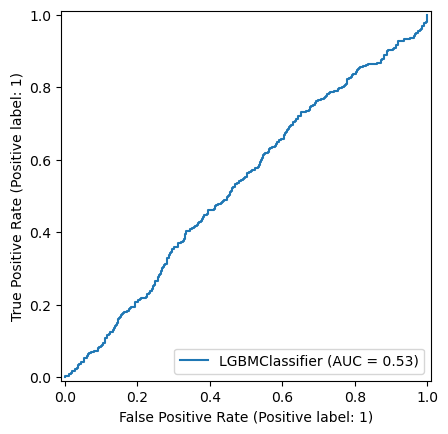

In [33]:
lgb_tuned.fit(X_train, y_train)
y_pred1 = lgb_tuned.predict(X_test1)
print_results(lgb_tuned, X_test1, y_test1, y_pred1)

RF accuracy: 0.5696846388606307
RF precision: 0.6470588235294118
RF recall: 0.7181528662420382


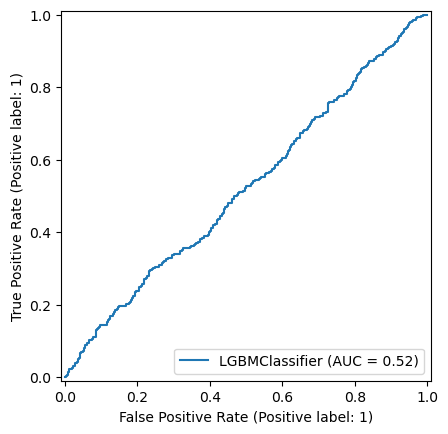

In [34]:
y_pred2 = lgb_tuned.predict(X_test2)
print_results(lgb_tuned, X_test2, y_test2, y_pred2)

In [35]:
# Create a DataFrame for better visualization
feature_importances = lgb_tuned.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

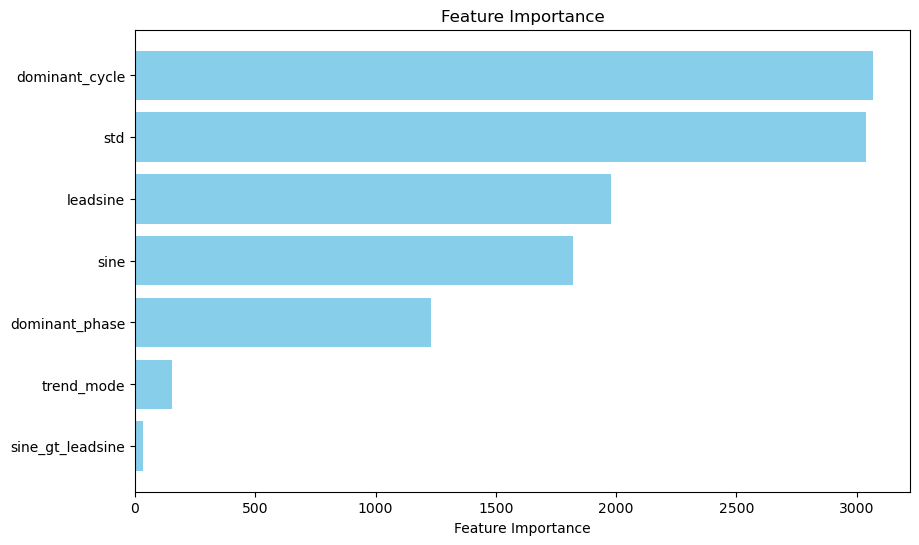

In [36]:
# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To show the highest importance at the top
plt.show()

######################## Returns #####################################

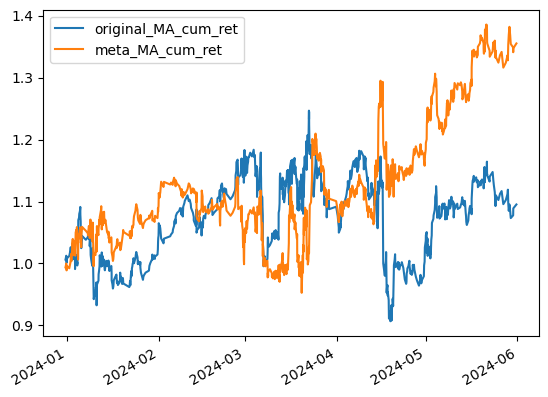

In [37]:
bins_ma_test = bins_bb.loc[bins_bb.index > split_date2].copy()
bins_ma_test['y_pred'] = y_pred2
bins_ma_test['y_pred'].replace(0, -1, inplace=True)
bins_ma_test['meta_signal_ret'] = bins_ma_test['ret']*bins_ma_test['y_pred']
bins_ma_test['original_MA_cum_ret'] = (1+bins_ma_test['ret']).cumprod()
bins_ma_test['meta_MA_cum_ret'] = (1+bins_ma_test['meta_signal_ret']).cumprod()
bins_ma_test[['original_MA_cum_ret','meta_MA_cum_ret']].plot()
plt.show()

In [38]:
import numpy as np
import pandas as pd

# Assuming you have a DataFrame with 'ret' and 'meta_MA_ret' columns
# bins_ma_test = pd.DataFrame(...)  # Your dataframe



# Calculate the summary for both strategies
summary_ret = summarize_backtest_stats(bins_ma_test['ret'])
summary_meta_MA_ret = summarize_backtest_stats(bins_ma_test['meta_signal_ret'])

# Convert the summaries into a DataFrame for easier comparison
summary_df = pd.DataFrame([summary_ret, summary_meta_MA_ret], index=['Strategy 1 (ret)', 'Strategy 2 (meta_ret)'])

summary_df

Sharpe Ratio  Max Drawdown  Underwater Time (days)  \
Strategy 1 (ret)           0.230366     -0.272570                     942   
Strategy 2 (meta_ret)      0.592821     -0.163905                     928   

                       Hit Ratio  Cumulative Return  Calmar Ratio  
Strategy 1 (ret)        0.638861           0.095217      0.089553  
Strategy 2 (meta_ret)   0.569685           0.355010      0.555258

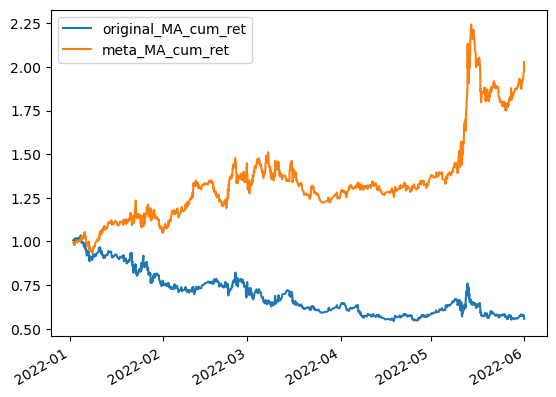

In [39]:
bins_ma_test = bins_bb.loc[bins_bb.index < split_date1].copy()
bins_ma_test['y_pred'] = y_pred1
bins_ma_test['y_pred'].replace(0, -1, inplace=True)
bins_ma_test['meta_signal_ret'] = bins_ma_test['ret']*bins_ma_test['y_pred']
bins_ma_test['original_MA_cum_ret'] = (1+bins_ma_test['ret']).cumprod()
bins_ma_test['meta_MA_cum_ret'] = (1+bins_ma_test['meta_signal_ret']).cumprod()
bins_ma_test[['original_MA_cum_ret','meta_MA_cum_ret']].plot()
plt.show()

In [40]:
# Calculate the summary for both strategies
summary_ret = summarize_backtest_stats(bins_ma_test['ret'])
summary_meta_MA_ret = summarize_backtest_stats(bins_ma_test['meta_signal_ret'])

# Convert the summaries into a DataFrame for easier comparison
summary_df = pd.DataFrame([summary_ret, summary_meta_MA_ret], index=['Strategy 1 (ret)', 'Strategy 2 (meta_MA_ret)'])

summary_df

Sharpe Ratio  Max Drawdown  Underwater Time (days)  \
Strategy 1 (ret)             -0.543297     -0.475762                    1271   
Strategy 2 (meta_MA_ret)      0.858342     -0.219437                    1182   

                          Hit Ratio  Cumulative Return  Calmar Ratio  
Strategy 1 (ret)           0.617969          -0.443067     -0.183346  
Strategy 2 (meta_MA_ret)   0.584375           1.028024      0.922324

In [41]:
(9/7)*0.081531

0.10482557142857145